# Compare abstract embedding vs. full text paper AI summary embedding

In [23]:
from rolling.pdf import list_pdfs, read_pdf
pdfs = list_pdfs()
len(pdfs), pdfs[:3]

(1000,
 ['./arxiv_downloads\\0812.0743v2.A_Novel_Clustering_Algorithm_Based_on_Quantum_Games.pdf',
  './arxiv_downloads\\1103.4487v1.Handwritten_Digit_Recognition_with_a_Committee_of_Deep_Neural_Nets_on_GPUs.pdf',
  './arxiv_downloads\\1106.4509v1.Machine_Learning_Markets.pdf'])

In [24]:
import re

def clean_text(txt):
    return re.sub(r"\s+", " ", txt).strip()

In [25]:
papers = [read_pdf(path) for path in pdfs] # takes a while
papers = [clean_text(txt) for txt in papers]

Ignoring wrong pointing object 8 0 (offset 0)
Ignoring wrong pointing object 10 0 (offset 0)
Ignoring wrong pointing object 12 0 (offset 0)
Ignoring wrong pointing object 17 0 (offset 0)
Ignoring wrong pointing object 19 0 (offset 0)
Ignoring wrong pointing object 28 0 (offset 0)
Ignoring wrong pointing object 42 0 (offset 0)
Ignoring wrong pointing object 59 0 (offset 0)
Ignoring wrong pointing object 90 0 (offset 0)
could not convert string to float: b'0.00-5836487' : FloatObject (b'0.00-5836487') invalid; use 0.0 instead
could not convert string to float: b'0.00-5836487' : FloatObject (b'0.00-5836487') invalid; use 0.0 instead
Ignoring wrong pointing object 39 0 (offset 0)
Multiple definitions in dictionary at byte 0x12e6 for key /ToUnicode
Multiple definitions in dictionary at byte 0x1221 for key /ToUnicode
could not convert string to float: b'0.00-10' : FloatObject (b'0.00-10') invalid; use 0.0 instead
could not convert string to float: b'0.00-10' : FloatObject (b'0.00-10') invali

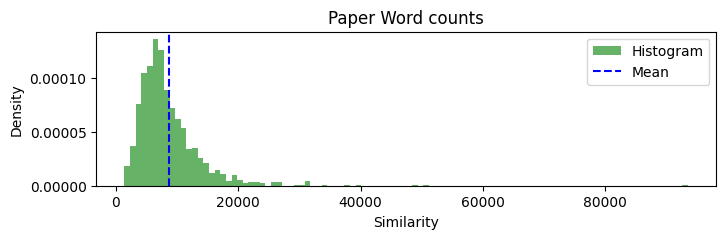

Mean: 8654.13500, Max 93568


In [27]:
import numpy as np
import matplotlib.pyplot as plt

# gain some insight into how large the papers actually are
# the model I intend to use has a context window of 131072 tokens
# each word being ~1.7 tokens on avg (experiment), this would allow for 77100 words at most
# since the ollama model interface truncates longer inputs, this should not be an issue
lengths = [len(txt.split(" ")) for txt in papers]
lengths = np.array(lengths)
mean = np.mean(lengths)

plt.figure(figsize=(8, 2))
plt.hist(lengths, bins=100, density=True, alpha=0.6, color='g', label='Histogram')
plt.axvline(x=mean, color='b', linestyle='--', label='Mean')

plt.xlabel('Similarity')
plt.ylabel('Density')
plt.title('Paper Word counts')
plt.legend()
plt.show()

print(f'Mean: {mean:.5f}, Max {lengths.max()}')

In [3]:
failed = []

In [4]:
max_context_length = 36000

In [11]:
import json
import pydantic
import ollama
from ollama import chat
from ollama import ChatResponse


class Summary(pydantic.BaseModel):
    contributions: list[str]
    problems_or_goals: list[str]


def summarize(paper):
    try:
        # # compute required context, because unnecessary size slows down the generation
        word_count = len(paper.split(' '))
        context_window_required = word_count * 1.8
        if context_window_required > max_context_length:
            # changing the context length every request re-deploys the model an is very inefficient
            # better to just skip a few..
            raise Exception('Too large, skip') 
        # context_window_required = min(context_window_required, 131072) # max for this model

        # test first 165 I used gemma3:27b, but it took ages
        response = ollama.generate(
            model="gemma3:latest",
            prompt=f"Given the following scientific paper, summarize their stands:\n---\n{paper}",
            format=Summary.model_json_schema(),
            options={
                "num_ctx": max_context_length,
            },
        )
        response = response['response']
        response = Summary.model_validate_json(response)
        return response
    except Exception as e:
        global failed
        failed.append(paper)
        print(e)
        return None

In [3]:
def get_paper_id_by_filename(pdf):
    """
    Examples:
        './arxiv_downloads\\0812.0743v2.A_Novel_Clustering_Algorithm_Based_on_Quantum_Games.pdf'
        './arxiv_downloads\\1103.4487v1.Handwritten_Digit_Recognition_with_a_Committee_of_Deep_Neural_Nets_on_GPUs.pdf'
        './arxiv_downloads\\1106.4509v1.Machine_Learning_Markets.pdf'
    """

    id = pdf.split('\\')[1]
    id = id.split('.')[0:2]
    id[1] = id[1].split('v')[0]
    return '.'.join(id)

# get_paper_id_by_filename(pdfs[1])

In [4]:
import os
output_dir = './arxiv_ai_paper_summary'
os.makedirs(output_dir, exist_ok=True)

In [5]:
import json
def save_summary(id, summary):
    file_name = os.path.join(output_dir, f'{id}.json')
    content = json.dumps(summary.__dict__, indent=2)
    with open(file_name, 'w', encoding='utf-8') as f:
        f.write(content)

# save_summary("abc", x)

In [12]:
import tqdm

for pdf_path in tqdm.tqdm(pdfs, total=len(pdfs)):
    try:
        paper_id = get_paper_id_by_filename(pdf_path)

        file_name = os.path.join(output_dir, f"{paper_id}.json")
        if os.path.exists(file_name):
            # to handle restart etc.. when error occurr
            continue

        paper = read_pdf(pdf_path)
        summary = summarize(paper)
        save_summary(paper_id, summary)
    except Exception as e:
        print(f"Error: {e}")
        continue

  8%|▊         | 80/1000 [00:00<00:06, 139.31it/s]

Too large, skip
Error: 'NoneType' object has no attribute '__dict__'


 18%|█▊        | 183/1000 [01:05<17:20,  1.27s/it]

Too large, skip
Error: 'NoneType' object has no attribute '__dict__'


 34%|███▍      | 344/1000 [11:22<28:23,  2.60s/it]  

Too large, skip
Error: 'NoneType' object has no attribute '__dict__'


 38%|███▊      | 385/1000 [14:12<38:24,  3.75s/it]  

Too large, skip
Error: 'NoneType' object has no attribute '__dict__'


 40%|████      | 401/1000 [15:07<25:30,  2.56s/it]

Too large, skip
Error: 'NoneType' object has no attribute '__dict__'


 43%|████▎     | 428/1000 [17:27<33:11,  3.48s/it]  Multiple definitions in dictionary at byte 0x12e6 for key /ToUnicode
Multiple definitions in dictionary at byte 0x1221 for key /ToUnicode
 45%|████▍     | 447/1000 [18:39<31:54,  3.46s/it]

Too large, skip
Error: 'NoneType' object has no attribute '__dict__'


 48%|████▊     | 476/1000 [20:34<42:30,  4.87s/it]could not convert string to float: b'0.00-10' : FloatObject (b'0.00-10') invalid; use 0.0 instead
could not convert string to float: b'0.00-10' : FloatObject (b'0.00-10') invalid; use 0.0 instead
could not convert string to float: b'0.00-10' : FloatObject (b'0.00-10') invalid; use 0.0 instead
could not convert string to float: b'0.00-10' : FloatObject (b'0.00-10') invalid; use 0.0 instead
could not convert string to float: b'0.00-40' : FloatObject (b'0.00-40') invalid; use 0.0 instead
could not convert string to float: b'0.00-40' : FloatObject (b'0.00-40') invalid; use 0.0 instead
could not convert string to float: b'0.00-40' : FloatObject (b'0.00-40') invalid; use 0.0 instead
could not convert string to float: b'0.00-40' : FloatObject (b'0.00-40') invalid; use 0.0 instead
could not convert string to float: b'0.00-24015747' : FloatObject (b'0.00-24015747') invalid; use 0.0 instead
could not convert string to float: b'0.0000-3937008' : F

KeyboardInterrupt: 

---
# analyze the results to find some patterns in the summary
One thing I noticed is that sometimes the model hallucinates (too much or too few) text
I'd like to disregard those samples

In [6]:
summaries = []

for file in os.listdir(output_dir):
    path = os.path.join(output_dir, file)
    with open(path, 'r', encoding='utf-8') as f:
        s_json = " ".join(f.readlines())
    summaries.append(json.loads(s_json))

In [7]:
summaries[0].keys()

dict_keys(['contributions', 'problems_or_goals'])

In [8]:
contribution_lengths = []
contribution_counts = []
problem_lengths = []
problem_counts = []

import numpy as np
for s in summaries:
    contribution_counts.append(len(s['contributions']))
    problem_counts.append(len(s['problems_or_goals']))
    contribution_lengths.append(np.mean([len(x) for x in s['contributions']]))
    problem_lengths.append(np.mean([len(x) for x in s['problems_or_goals']]))

stats_contribution_lengths = [np.mean(contribution_lengths), np.std(contribution_lengths)]
stats_contribution_counts = [np.mean(contribution_counts), np.std(contribution_counts)]
stats_problem_lengths = [np.mean(problem_lengths), np.std(problem_lengths)]
stats_problem_counts = [np.mean(problem_counts), np.std(problem_counts)]

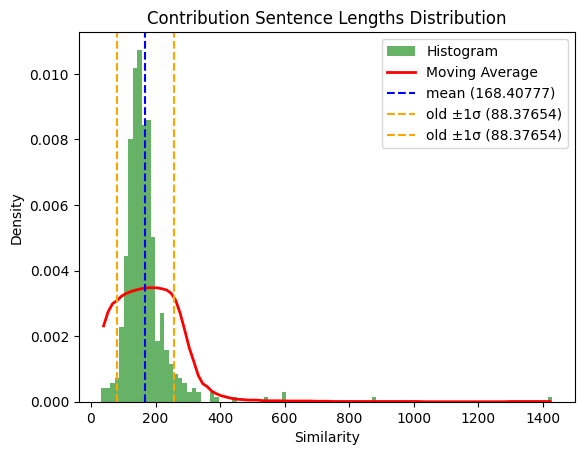

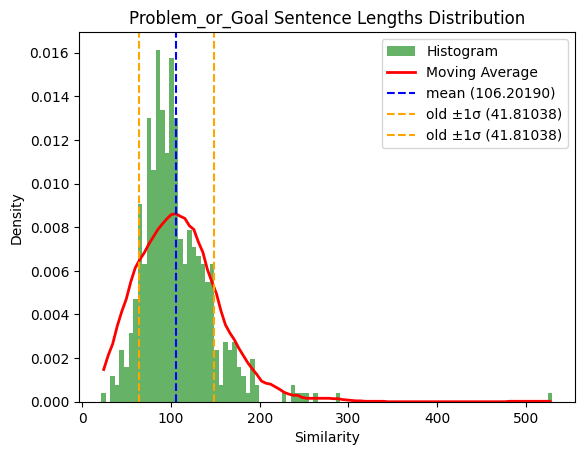

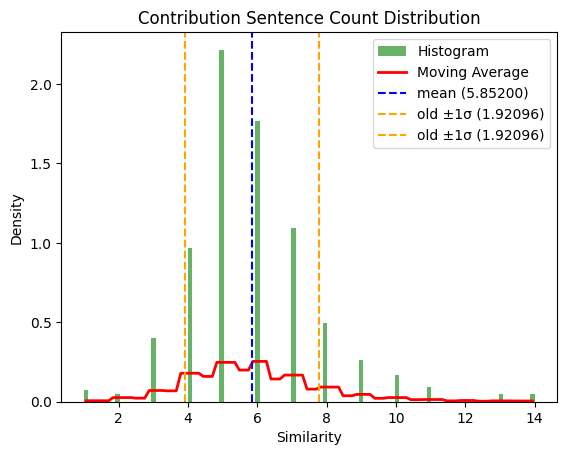

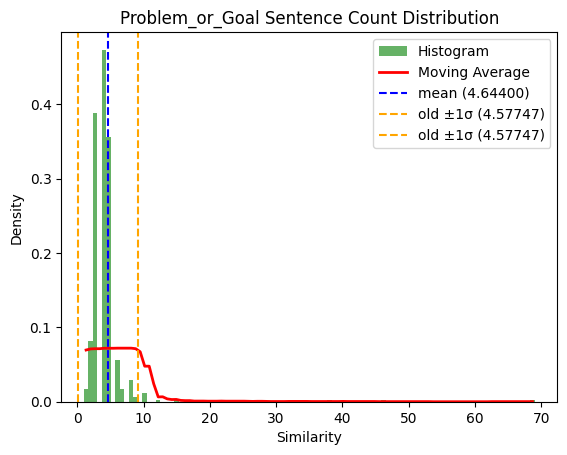

In [9]:
def plot_values(title, values, mean, std_dev):
    import numpy as np
    import matplotlib.pyplot as plt

    count, bins, _ = plt.hist(values, bins=100, density=True, alpha=0.6, color='g', label='Histogram')

    window_size = 20
    moving_avg = np.convolve(count, np.ones(window_size)/window_size, mode='same')
    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    plt.plot(bin_centers, moving_avg, color='r', label='Moving Average', linewidth=2)

    plt.axvline(x=mean, color='b', linestyle='--', label=f'mean ({mean:.5f})')
    plt.axvline(x=mean - std_dev, color='orange', linestyle='--', label=f'old ±1σ ({std_dev:.5f})')
    plt.axvline(x=mean + std_dev, color='orange', linestyle='--', label=f'old ±1σ ({std_dev:.5f})')

    plt.xlabel('Similarity')
    plt.ylabel('Density')
    plt.title(f'{title} Distribution')
    plt.legend()
    plt.show()

plot_values('Contribution Sentence Lengths', contribution_lengths, *stats_contribution_lengths)
plot_values('Problem_or_Goal Sentence Lengths', problem_lengths, *stats_problem_lengths)
plot_values('Contribution Sentence Count', contribution_counts, *stats_contribution_counts)
plot_values('Problem_or_Goal Sentence Count', problem_counts, *stats_problem_counts)

---
# check to see how different the embeddings actually are

In [10]:
from elasticsearch import Elasticsearch
client = Elasticsearch("http://localhost:9200/", api_key="a1VxLUZaWUJ6Q1VRYXlSWTJSX2U6RWx3X0xQbXZURnlsNGU5UmNFeWZhZw==") # localhost

In [11]:
from rolling.embedding import GTEEmbeddingModel
model = GTEEmbeddingModel()

In [12]:
def fetch_paper(id):
    return client.get(
        index="arxiv",
        id=id,
    )

In [14]:
embeddings = []

for file in os.listdir(output_dir):
    path = os.path.join(output_dir, file)
    id = file.split('.json')[0]
    with open(path, 'r', encoding='utf-8') as f:
        s_json = " ".join(f.readlines())
    summary = json.loads(s_json)

    _contribution_lengths = np.mean([len(x) for x in summary['contributions']])
    _contribution_counts = len(summary['contributions'])
    _problem_lengths = np.mean([len(x) for x in summary['problems_or_goals']])
    _problem_counts = len(summary['problems_or_goals'])

    is_ok = (
        (sum(stats_contribution_lengths) *1.5 > _contribution_lengths > stats_contribution_lengths[0] - stats_contribution_lengths[1]*1.5) &
        (sum(stats_contribution_counts) *1.5 > _contribution_counts > stats_contribution_counts[0] - stats_contribution_counts[1]*1.5) &
        (sum(stats_problem_lengths) *1.5 > _problem_lengths > stats_problem_lengths[0] - stats_problem_lengths[1]*1.5) &
        (sum(stats_problem_counts) *1.5 > _problem_counts > stats_problem_counts[0] - stats_problem_counts[1]*1.5)
    )
    if not is_ok:
        print(f'ID {file} outside acceptable value range, skipping')
        continue

    paper = fetch_paper(id)['_source']
    embedding_data = {
        "title": paper["title"],
    }
    embedding_data.update(summary)
    embedding_data = json.dumps(embedding_data)
    embedding = model.encode(embedding_data)[0]

    embeddings.append((embedding, paper['embedding']))

ID 1409.2944.json outside acceptable value range, skipping
ID 1506.01911.json outside acceptable value range, skipping
ID 1506.02617.json outside acceptable value range, skipping
ID 1506.06714.json outside acceptable value range, skipping
ID 1507.06947.json outside acceptable value range, skipping
ID 1602.04484.json outside acceptable value range, skipping
ID 1603.08023.json outside acceptable value range, skipping
ID 1605.06069.json outside acceptable value range, skipping
ID 1605.07427.json outside acceptable value range, skipping
ID 1611.01576.json outside acceptable value range, skipping
ID 1612.04052.json outside acceptable value range, skipping
ID 1702.08690.json outside acceptable value range, skipping
ID 1703.06692.json outside acceptable value range, skipping
ID 1704.02882.json outside acceptable value range, skipping
ID 1706.03946.json outside acceptable value range, skipping
ID 1707.00703.json outside acceptable value range, skipping
ID 1708.02735.json outside acceptable val

In [15]:
len(embeddings)

457

In [16]:
from rolling.embedding import get_similarity
similarities = [
    get_similarity(emb1, emb2)
    for emb1, emb2 in embeddings
    if emb1 is not None
]

import numpy as np
similarities = np.array(similarities)

In [17]:
similarities.shape

(457,)

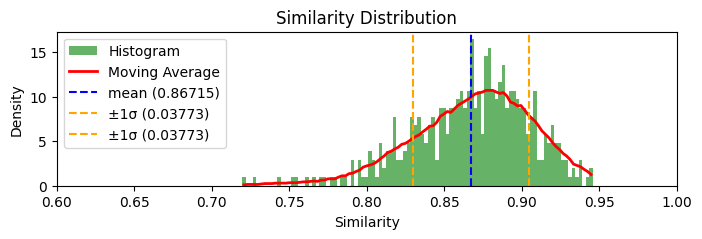

In [22]:

import numpy as np
import matplotlib.pyplot as plt

mean = np.mean(similarities)
std_dev = np.std(similarities)

plt.figure(figsize=(8, 2))

count, bins, _ = plt.hist(similarities, bins=100, density=True, alpha=0.6, color='g', label='Histogram')

window_size = 20
moving_avg = np.convolve(count, np.ones(window_size)/window_size, mode='same')
bin_centers = 0.5 * (bins[1:] + bins[:-1])
plt.plot(bin_centers, moving_avg, color='r', label='Moving Average', linewidth=2)

plt.axvline(x=mean, color='b', linestyle='--', label=f'mean ({mean:.5f})')
plt.axvline(x=mean - std_dev, color='orange', linestyle='--', label=f'±1σ ({std_dev:.5f})')
plt.axvline(x=mean + std_dev, color='orange', linestyle='--', label=f'±1σ ({std_dev:.5f})')

plt.xlim(0.6, 1.0)

plt.xlabel('Similarity')
plt.ylabel('Density')
plt.title('Similarity Distribution')
plt.legend()
plt.show()